In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Embedding
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime
from tqdm import tqdm
print(f'Current Step #01 [now = {datetime.now()}')


In [3]:
results = {}

In [4]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    # print(metrics)
    if len(metrics) > 0:
        metrics = metrics[0].split('|')
        return metrics[0], metrics[1] 
    return [], []


def load_data(version="T_01_10", db_file_path='../db/metrics.db', random_state=113789):
    rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
    rounds = []
    matched_cnts = []
    if len(rounds_str) > 0 and len(matched_cnts_str) > 0:
        for i in rounds_str.split(','):
            rounds.append(int(i))
        for i in matched_cnts_str.split(','):
            matched_cnts.append(int(i))
        rounds.reverse()
        matched_cnts.reverse()
        df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
        return df
    return None


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


print(f'Current Step #01 [now = {datetime.now()}')

Current Step #01 [now = 2025-06-27 23:59:25.919204


In [5]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


In [6]:
from enum import Enum

class ScalerType(Enum):
    PRIVATE=0,
    STANDARD=1,
    MIN_MAX=2


def restore_private(data, min, mux, divider):
    new_data = []
    for i in data:
        cleaned = i[0] - min
        if cleaned < 0.0:
            cleaned = 0.
        new_data.append(cleaned)
    restored = np.array([[(round(i, 6)*mux)] for i in new_data])
    return restored    

"""
            new_data = []
            for i in data[0]:
                cleaned = i[0] * self._divider - self.p_min
                if cleaned < 0:
                    cleaned = 0.
                new_data.append(cleaned)
            restored = np.array([[(round((cleaned*self.p_mux),3)/10.0)] for i in new_data])

"""

class PrivateScaler:
    def __init__(self, divider=6.0):
        """" __init___ """
        self._divider = divider
        self.p_max = 1
        self.p_min = -1
        self.p_mux = 1

    def adjust_parameter1(self, data, add_mux):
        if len(data) > 1:
            if self.p_min == -1:
                self.p_max = data.max() * self._divider
                self.p_min = data.min() * self._divider
                max_diff_val = self.p_max - self.p_min
                print('min, max, diff', self.p_min, self.p_max, max_diff_val)
                while (max_diff_val * self.p_mux) < 1.:
                    self.p_mux *= 10
                self.p_mux += add_mux
        else:
            pass

    def adjust_parameter(self, data, add_mux):
        if len(data) > 1:
            if self.p_min == -1:
                self.p_max = data.max()
                self.p_min = data.min()
                max_diff_val = self.p_max - self.p_min
                print('min, max, diff', self.p_min, self.p_max, max_diff_val)
                while (max_diff_val * self.p_mux) < 0.1:
                    self.p_mux *= 10
                self.p_mux += add_mux
        else:
            pass

    def fit_transform(self, data):
        """ fit_transform """
        self.p_max = data.max() + 1
        self._divider = self.p_max
        scaled_data = np.array([[round(float(i[0])/self._divider, 9)] for i in data])
        return scaled_data

    def inverse_transform1(self, data, add_mux=0.):
        """ inverse_transform """
        import math
        if data[1]:
            self.adjust_parameter(data[0], add_mux)
            # restored = np.array([[((i[0] * self._divider - self.p_min) * self.p_mux)] for i in data[0]])
            restored = np.array([[math.pow(round((i[0] * self._divider - self.p_min),3),2)] for i in data[0]])
        else:
            restored = np.array([[i[0] * self._divider] for i in data[0]])
        return restored

    def inverse_transform(self, data, add_mux=0.):
        """ inverse_transform """
        import math
        if data[1]:
            self.adjust_parameter(data[0], add_mux)
            # restored = np.array([[((i[0] * self._divider - self.p_min) * self.p_mux)] for i in data[0]])
            restored = restore_private(data[0], self.p_min, self.p_mux, self._divider)
        else:
            restored = np.array([[i[0] * self._divider] for i in data[0]])
        return restored


scaler_cls = {
    ScalerType.PRIVATE: PrivateScaler,
    ScalerType.STANDARD: StandardScaler,
    ScalerType.MIN_MAX: MinMaxScaler # feature_range=(0,1)
    }


class DataScaling():
    def __init__(self, scaler_type: ScalerType, *args: list):
        self._scaler_type = scaler_type
        self._scaler_cls = scaler_cls[scaler_type](*args)

    def fit_transform(self, data):
        return self._scaler_cls.fit_transform(data)

    def inverse_transform(self, datas: list):
        inversed_data = []
        min = -1
        max = 1
        mux = -1
        div = 1
        if self._scaler_type == ScalerType.PRIVATE:
            for data in datas:
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform((data[0].reshape(-1, 1), data[2]))
                else:
                    inversed = self._scaler_cls.inverse_transform((data[0], data[2]))
                inversed_data.append(inversed)
            min = self._scaler_cls.p_min
            max = self._scaler_cls.p_max
            mux = self._scaler_cls.p_mux
            div = self._scaler_cls._divider
        else:
            cnt = 1
            for data in datas:
                cnt += 1
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform(data[0].reshape(-1, 1))
                else:
                    inversed = self._scaler_cls.inverse_transform(data[0])
                inversed_data.append(inversed)
            min = 0
        return inversed_data, min, max, mux, div


### 최종 결과 입니다.
def analyze_v1(random_state,
               version,
               db_file_path,
               scaler_type=ScalerType.PRIVATE,
               layers=[(False)],
               activation='sigmoid',
               units=50,
               draw_graph=True,
               sequence_length=10,
               optimizer="adam",
               loss='mean_squared_error',
               add_mux=0,
               verbose=0):
    """
     - loss = [binary_crossentropy, mean_squared_error, ]
     - optimizer = [adam, ]

    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # 1. Prepare the Data
    # Create sample time series data
    df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
    if df is None:
        return -1, '', random_state

    if verbose > 0:
        print('df', df)
    if verbose > 0:
        print(f'Current Step #02 [now = {datetime.now()}]')

    data = df['matched_cnts'].values.reshape(-1, 1)

    # Normalize the data
    scaler = DataScaling(scaler_type)
    scaled_data = scaler.fit_transform(data)
    if verbose > 0:
        print(f'Current Step #04 [now = {datetime.now()}]')

    # Define sequence length (timesteps)

    # Create sequences for training
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    # print('X=', X)
    # print('y=', y)
    if verbose > 0:
        print(f'Current Step #06 [now = {datetime.now()}]')

    # Reshape X for LSTM input (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    if verbose > 0:
        print(f'Current Step #08 [now = {datetime.now()}]')

    # Split data into training and testing sets
    # train_size = int(len(X) * 0.8)
    train_size = int(len(X) * 0.8)

    X_train, X_test, X_last = X[:train_size], X[train_size:], np.array([[y[-1:]]])
    y_train, y_test = y[:train_size], y[train_size:]
    if verbose > 0:
        print(f'Current Step #10 [now = {datetime.now()}]')

    # print('len (train) = ', len(X_train), len(X_train[0]))
    # print('len (test ) = ', len(X_test), len(X_test[0]))
    # return [], [], [], []
    
    tf.random.set_seed(random_state)

    # 2. Build the LSTM Model
    model = Sequential()
    input_shape = (X_train.shape[1], 1)
    embedding_dim = 1
    max_len = sequence_length
    vocab_size = len(data)
    # print('input_shape', input_shape)
    
    # if is_bidirectional = :
    # else:
    model.add(Input(shape=input_shape))
    for i in range(len(layers)):
        print(f'add layter [{i}]')
        if i < (len(layers) - 1):
            return_sequences=True
        else:
            return_sequences=False
        print(f'Bidirectional = {layers[i][0]}')
        if layers[i][0]==True:
            model.add(Bidirectional(LSTM(units=units,
                                         activation=activation,
                                         return_sequences=return_sequences),))
        else:
            model.add(LSTM(units=units,
                           activation=activation,
                           return_sequences=return_sequences))
                                    # input_shape=input_shape))

    # model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1)) # Output layer for predicting a single value
    if verbose > 0:
        print(f'Current Step #12 [now = {datetime.now()}]')

    # 3. Compile and Train the Model
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training

    if verbose > 0:
        print(f'Current Step #14 [now = {datetime.now()}]')

    # 4. Make Predictions
    train_predict = model.predict(X_train, verbose=verbose)
    test_predict = model.predict(X_test, verbose=verbose)
    last_predict_0 = model.predict(X_last, verbose=verbose)
    if verbose > 0:
        print(f'Current Step #16 [now = {datetime.now()}]')

    # Inverse transform predictions to original scale
    scaled_data1 = scaled_data
    # last_predict_0 = last_predict_0.reshape(-1, 1)
    train_predict_len = len(train_predict)
    test_predict_len = len(test_predict)
    last_predict_len = len(last_predict_0)
    print('lens  = ', train_predict_len, test_predict_len, last_predict_len)
    print('types = ', type(train_predict), type(test_predict), type(last_predict_0))

    # t_predict = np.concatenate((train_predict, test_predict, last_predict_0), axis=0)
    t_predict = np.concatenate((train_predict, test_predict), axis=0)
    wanted_datas = [(t_predict, False, True),
                    (last_predict_0, True, False),
                    (y_train, True, False),
                    (y_test, True, False),
                    (scaled_data, False, False)]
    inversed_datas, scaler_min, scaler_max, scaler_mux, scaler_div = scaler.inverse_transform(wanted_datas)
    t_predict = inversed_datas[0]
    last_predict = inversed_datas[1]
    y_train_original = inversed_datas[2]
    y_test_original = inversed_datas[3]
    scaled_data = inversed_datas[4]
    train_predict = t_predict[:train_predict_len]
    test_predict = t_predict[train_predict_len:train_predict_len+test_predict_len]
    print("scaler_min, scaler_max, scaler_mux, scaler_div", scaler_min, scaler_max, scaler_mux, scaler_div)
    # last_predict = t_predict[train_predict_len+test_predict_len:train_predict_len+test_predict_len+last_predict_len]
    if verbose > 0:
        print(f'Current Step #18 [now = {datetime.now()}]')

    # 5. Evaluate the Model (Optional, but recommended)
    from sklearn.metrics import mean_squared_error
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))

    if verbose > 0:
        print(f'Current Step #20 [now = {datetime.now()}]')
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
        print(f'random_state = {random_state}')
        print(f'last_prediction = {last_predict}')
        print(f'data_max_val = {scaled_data.max()}')
    # You can also visualize the results
    test_last_predict = test_predict[-1:]
    if draw_graph:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(scaled_data1, label='Original Data')
        plt.plot(np.arange(sequence_length,
                           sequence_length + len(train_predict)),
                 train_predict,
                 label='Train Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict),
                           sequence_length + len(train_predict) + len(test_predict)),
                 test_predict,
                 label='Test Predictions')
        # plt.plot(np.arange(sequence_length + len(train_predict) + len(test_predict),
        #          sequence_length + len(train_predict) + len(test_predict) + len(last_predict)),
        #          last_predict,
        #          label='Last Predictions')
        plt.xlabel(f'{random_state}\'s Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    restored_last_predict = restore_private(last_predict_0.reshape(-1, 1), scaler_min, scaler_mux, scaler_div)
    return {
        "scaled_data_max": scaled_data.max(),
        "scaled_data_min": scaled_data.min(),
        "last_predict": last_predict,
        "last_predict_or": last_predict_0,
        "restored_last_predict": restored_last_predict,
        "test_last_predict": test_last_predict,
        "X_last": X_last,
        "random_state": random_state,
        "scaler_min": scaler_min,
        "scaler_max": scaler_max,
        "scaler_mux": scaler_mux,
        "scaler_div": scaler_div
    }

print(f'Current work : {datetime.now()}')

Current work : 2025-06-27 23:59:28.597050


In [7]:
version = "T_01_13"
t_version = "T_01_93"
predict_result = []
print(f'Current work : {datetime.now()}')

Current work : 2025-06-27 23:59:29.655178


add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.16191779 0.1627423 0.00082451105
scaler_min, scaler_max, scaler_mux, scaler_div 0.16191779 0.1627423 1000.0 5


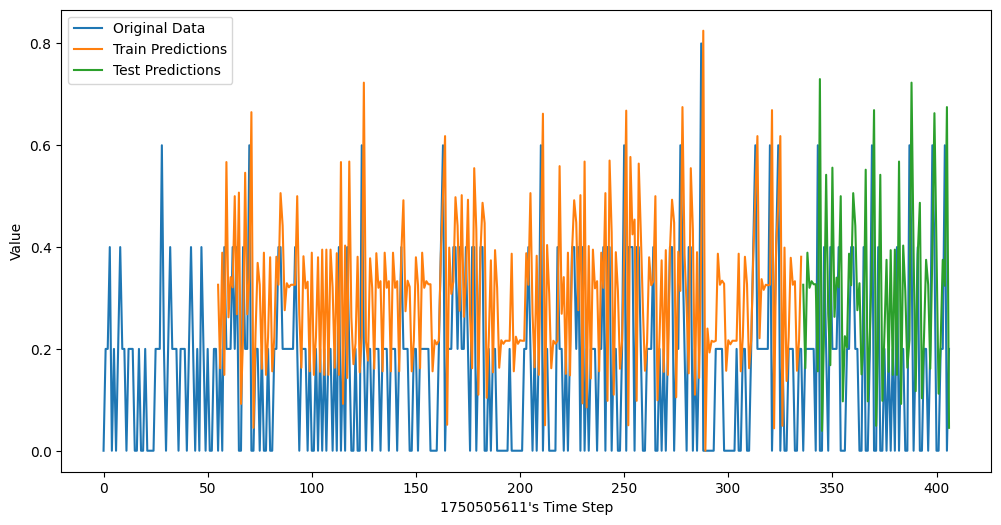

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.86647883]]), 'last_predict_or': array([[0.17329577]], dtype=float32), 'restored_last_predict': array([[11.377999]], dtype=float32), 'test_last_predict': array([[0.045]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 1750505611, 'scaler_min': np.float32(0.16191779), 'scaler_max': np.float32(0.1627423), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-28 00:13:59.786298


In [9]:
### Good Condition #1
# ('1750505611', 16, 'T_01_92')
t_version = 'T_01_92'
db_file_path = '../db/metrics.db'
random_state = 1750505611
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.20172386 0.21985523 0.018131375
scaler_min, scaler_max, scaler_mux, scaler_div 0.20172386 0.21985523 10.0 4


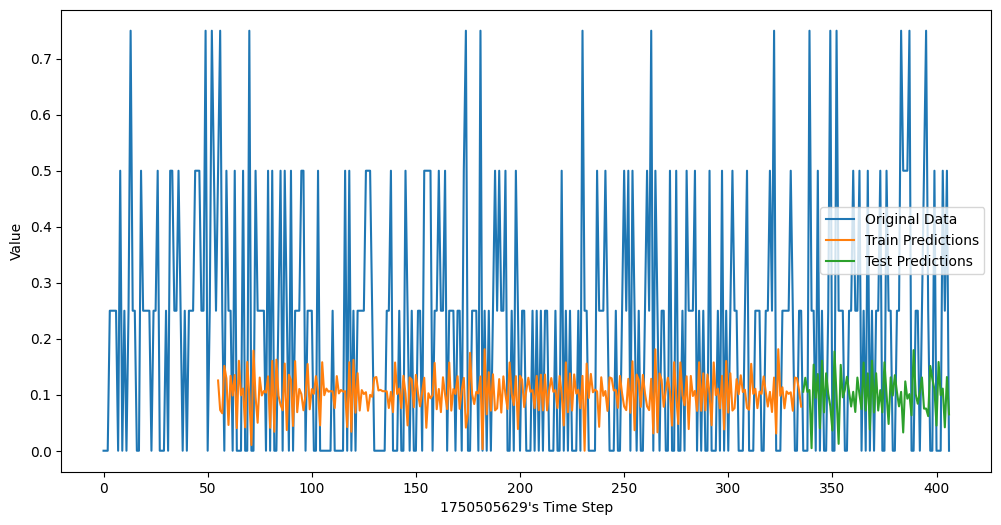

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.00040019]]), 'last_predict_or': array([[0.25010005]], dtype=float32), 'restored_last_predict': array([[0.48376]], dtype=float32), 'test_last_predict': array([[0.06492]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505629, 'scaler_min': np.float32(0.20172386), 'scaler_max': np.float32(0.21985523), 'scaler_mux': 10.0, 'scaler_div': np.int64(4)} now 2025-06-28 00:26:02.004521


In [10]:
### Good Condition #1
# ('1750505629', 16, 'T_01_92')
t_version = 'T_01_92'
db_file_path = '../db/metrics.db'
random_state = 1750505629
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 00:30:11.661062
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.1206592 0.13851957 0.017860368
scaler_min, scaler_max, scaler_mux, scaler_div 0.1206592 0.13851957 10.0 5


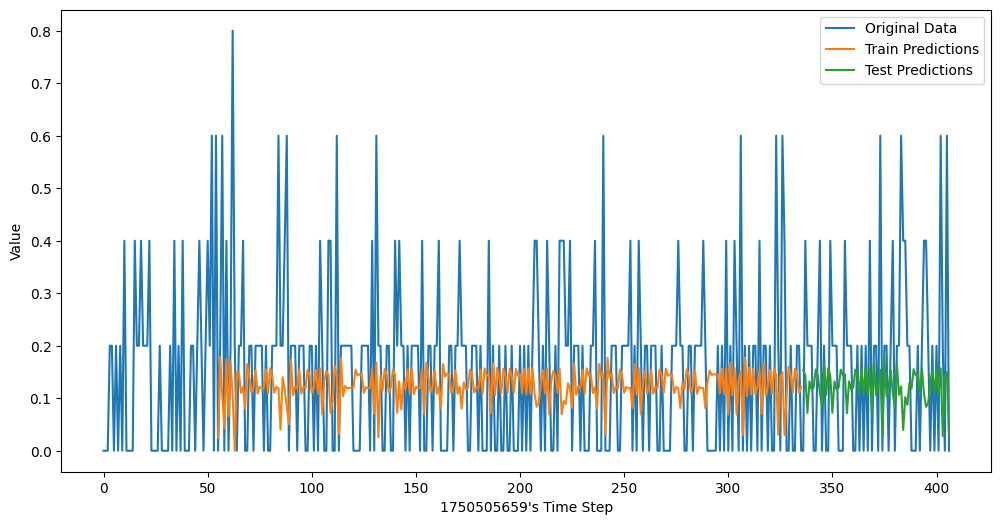

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.07062951]]), 'last_predict_or': array([[0.2141259]], dtype=float32), 'restored_last_predict': array([[0.93467]], dtype=float32), 'test_last_predict': array([[0.02967]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505659, 'scaler_min': np.float32(0.1206592), 'scaler_max': np.float32(0.13851957), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-28 00:36:46.702037


In [11]:
### Good Condition #1
# ('1750505659', 16, 'T_01_92')

t_version = 'T_01_92'
db_file_path = '../db/metrics.db'
random_state = 1750505659
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 00:48:57.770877
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.22785783 0.25826776 0.030409932
scaler_min, scaler_max, scaler_mux, scaler_div 0.22785783 0.25826776 10.0 4


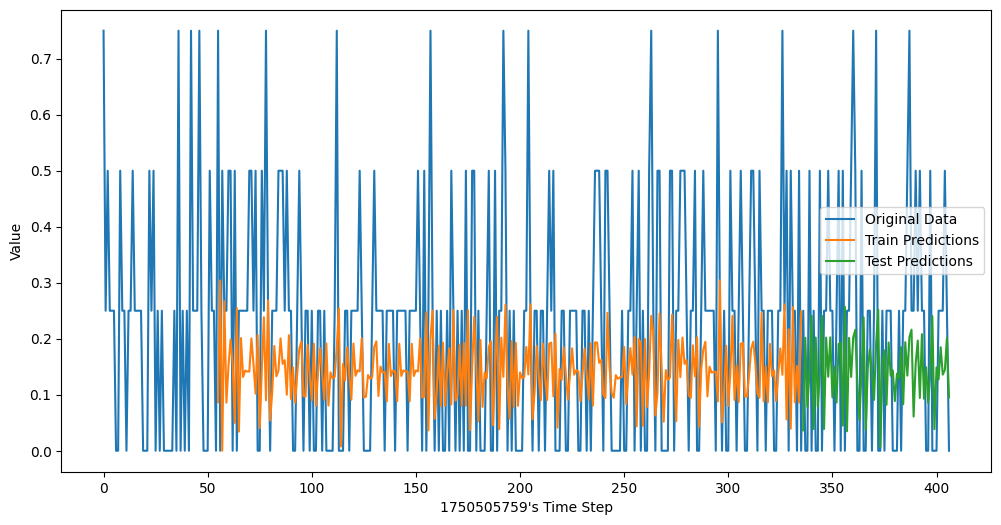

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.96308422]]), 'last_predict_or': array([[0.24077106]], dtype=float32), 'restored_last_predict': array([[0.12913]], dtype=float32), 'test_last_predict': array([[0.09524]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505759, 'scaler_min': np.float32(0.22785783), 'scaler_max': np.float32(0.25826776), 'scaler_mux': 10.0, 'scaler_div': np.int64(4)} now 2025-06-28 00:55:41.603128


In [12]:
### Good Condition #1
# ('1750505759', 16, 'T_01_92')

t_version = 'T_01_92'
db_file_path = '../db/metrics.db'
random_state = 1750505759
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 00:59:36.144954
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.20781675 0.20833445 0.00051769614
scaler_min, scaler_max, scaler_mux, scaler_div 0.20781675 0.20833445 1000.0 5


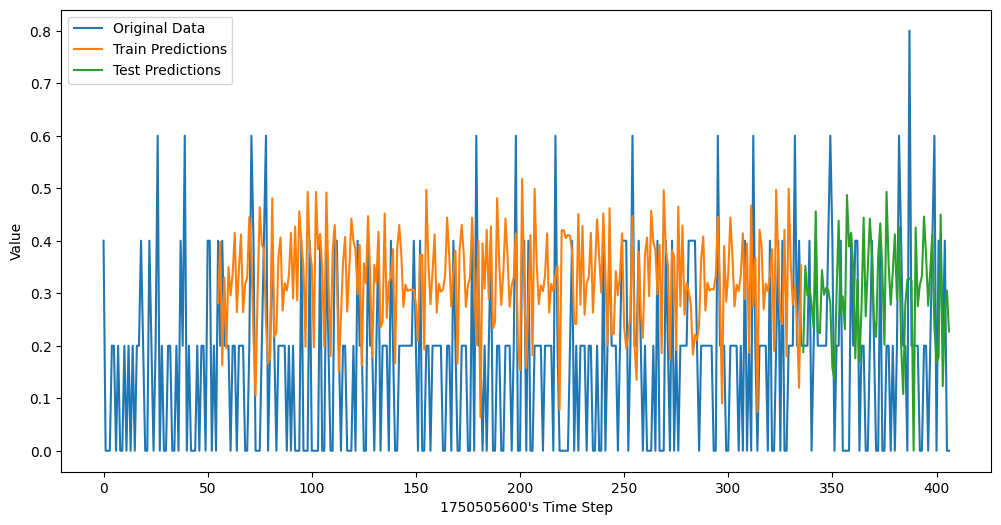

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.6695962]]), 'last_predict_or': array([[0.13391924]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.227]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505600, 'scaler_min': np.float32(0.20781675), 'scaler_max': np.float32(0.20833445), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-28 01:06:47.779326


In [14]:
### Good Condition #1
# ('1750505600', 15, 'T_01_92')

t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505600
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 01:07:38.083023
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.15237679 0.16628538 0.013908595
scaler_min, scaler_max, scaler_mux, scaler_div 0.15237679 0.16628538 10.0 5


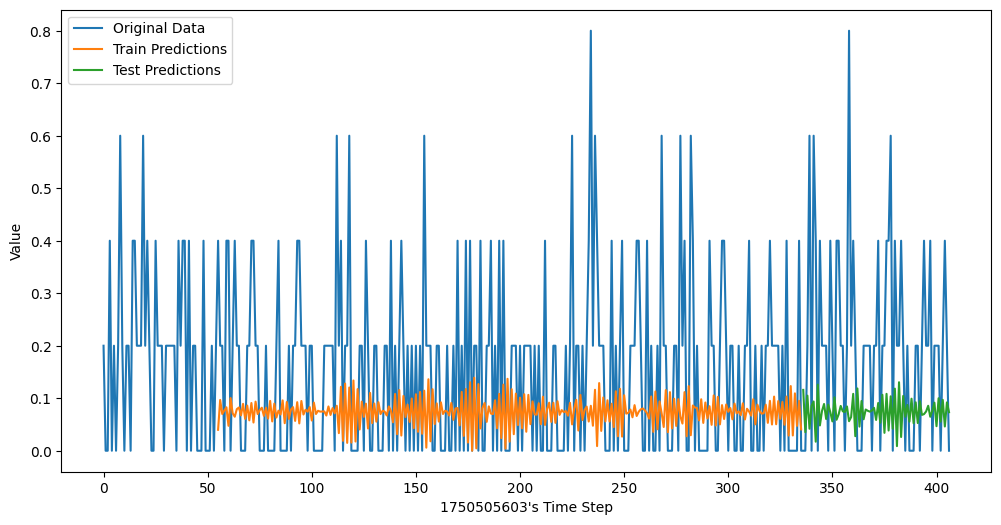

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.02566436]]), 'last_predict_or': array([[0.20513287]], dtype=float32), 'restored_last_predict': array([[0.52756]], dtype=float32), 'test_last_predict': array([[0.07336]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505603, 'scaler_min': np.float32(0.15237679), 'scaler_max': np.float32(0.16628538), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-28 01:14:15.530814


In [15]:
### Good Condition #1
# ('1750505603', 15, 'T_01_92')
t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505603
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 01:14:44.939754
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.15590718 0.18874116 0.03283398
scaler_min, scaler_max, scaler_mux, scaler_div 0.15590718 0.18874116 10.0 4


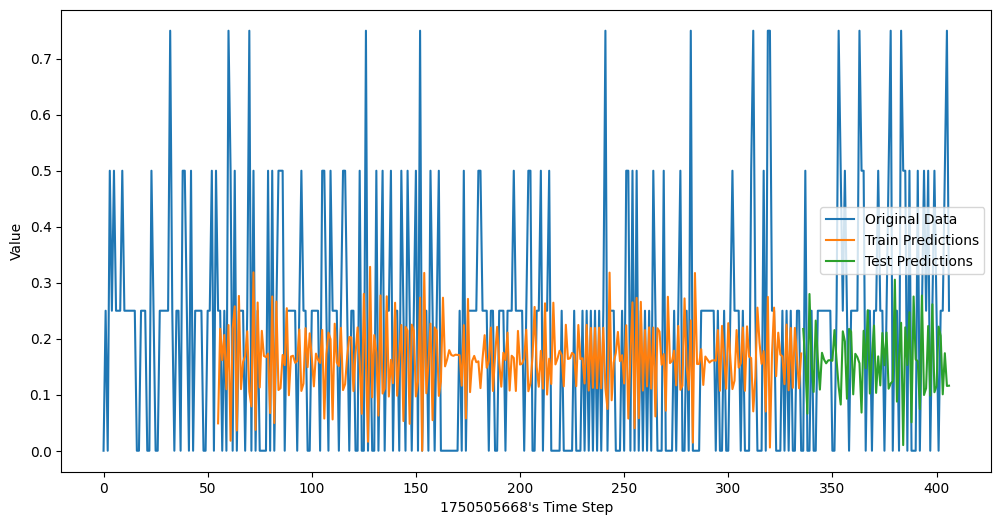

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.32320604]]), 'last_predict_or': array([[0.08080151]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.11614001]], dtype=float32), 'X_last': array([[[0.25]]]), 'random_state': 1750505668, 'scaler_min': np.float32(0.15590718), 'scaler_max': np.float32(0.18874116), 'scaler_mux': 10.0, 'scaler_div': np.int64(4)} now 2025-06-28 01:21:12.356978


In [16]:
### Good Condition #1
# ('1750505668', 15, 'T_01_92')
t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505668
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 01:21:51.119359
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.24208418 0.24310768 0.0010235012
scaler_min, scaler_max, scaler_mux, scaler_div 0.24208418 0.24310768 100.0 4


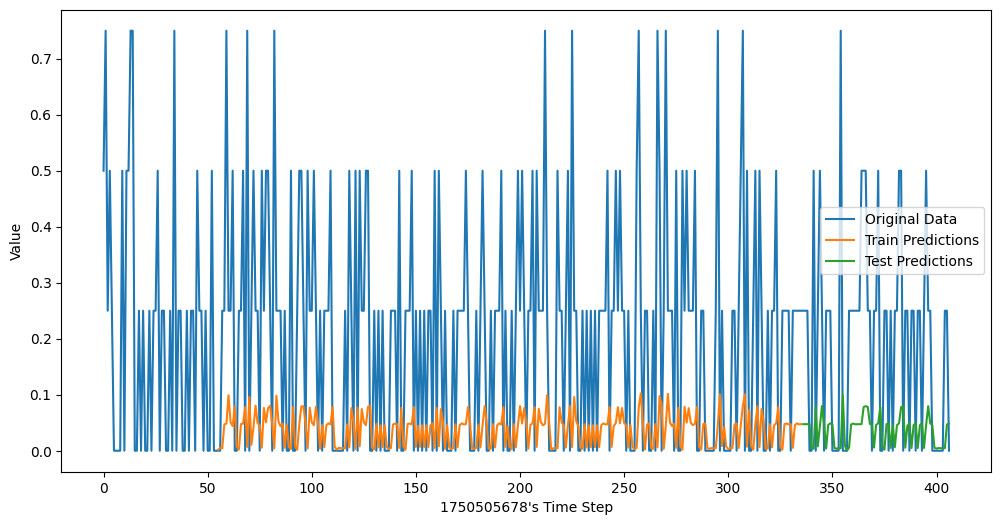

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.98851436]]), 'last_predict_or': array([[0.24712859]], dtype=float32), 'restored_last_predict': array([[0.5044]], dtype=float32), 'test_last_predict': array([[0.0484]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505678, 'scaler_min': np.float32(0.24208418), 'scaler_max': np.float32(0.24310768), 'scaler_mux': 100.0, 'scaler_div': np.int64(4)} now 2025-06-28 01:28:20.126832


In [17]:
### Good Condition #1
# ('1750505678', 15, 'T_01_92')
t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505678
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 01:28:52.114209
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.064983875 0.20538253 0.14039865
scaler_min, scaler_max, scaler_mux, scaler_div 0.064983875 0.20538253 1.0 5


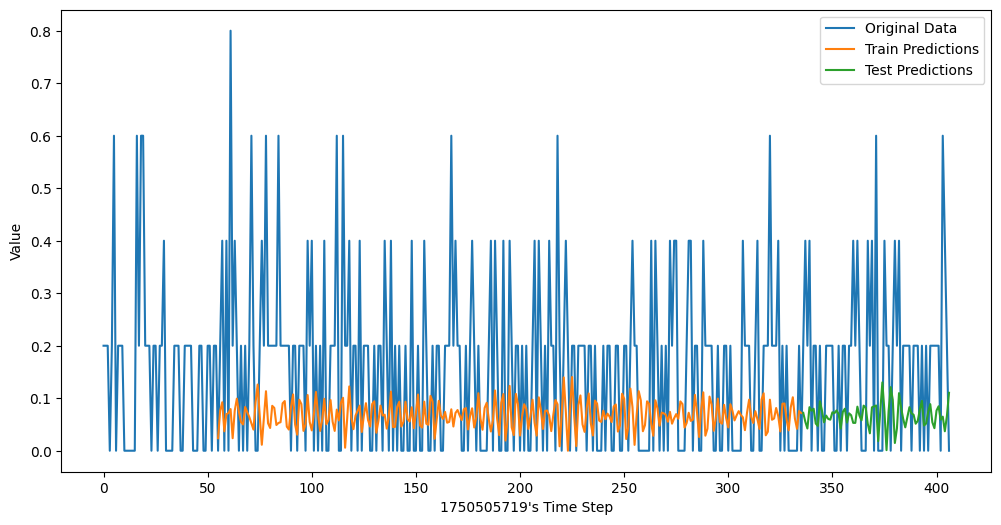

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.31803276]]), 'last_predict_or': array([[-0.06360655]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.110337]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505719, 'scaler_min': np.float32(0.064983875), 'scaler_max': np.float32(0.20538253), 'scaler_mux': 1.0, 'scaler_div': np.int64(5)} now 2025-06-28 01:34:07.807938


In [18]:
### Good Condition #1
# ('1750505719', 15, 'T_01_92')
t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505719
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 01:54:36.591389
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.19194143 0.19202621 8.478761e-05
scaler_min, scaler_max, scaler_mux, scaler_div 0.19194143 0.19202621 10000.0 5


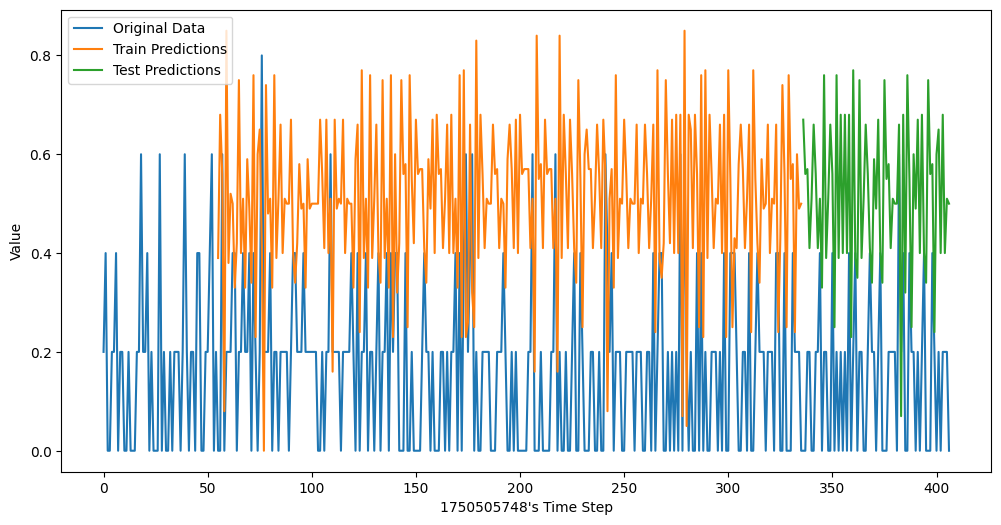

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.2473727]]), 'last_predict_or': array([[0.24947454]], dtype=float32), 'restored_last_predict': array([[575.33]], dtype=float32), 'test_last_predict': array([[0.5]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505748, 'scaler_min': np.float32(0.19194143), 'scaler_max': np.float32(0.19202621), 'scaler_mux': 10000.0, 'scaler_div': np.int64(5)} now 2025-06-28 02:00:13.923327


In [19]:
### Good Condition #1
# ('1750505748', 15, 'T_01_92')
t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505748
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-28 02:05:12.758375
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.13706562 0.13809316 0.0010275394
scaler_min, scaler_max, scaler_mux, scaler_div 0.13706562 0.13809316 100.0 5


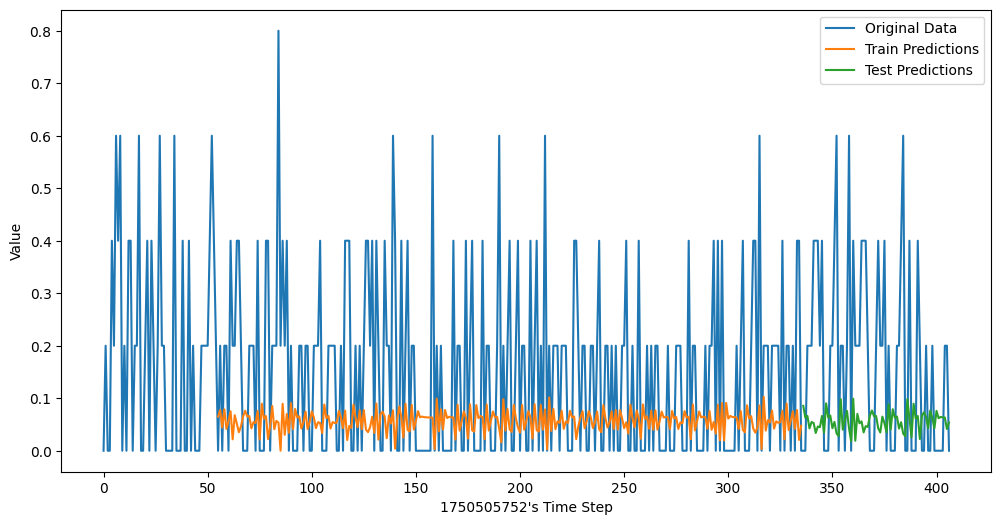

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.29192789]]), 'last_predict_or': array([[-0.05838558]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.0537]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 1750505752, 'scaler_min': np.float32(0.13706562), 'scaler_max': np.float32(0.13809316), 'scaler_mux': 100.0, 'scaler_div': np.int64(5)} now 2025-06-28 02:10:20.360347


In [20]:
### Good Condition #1
# ('1750505752', 15, 'T_01_92')
t_version = 'T_01_92'

db_file_path = '../db/metrics.db'
random_state = 1750505752
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [ ]:
"""
version TEXT, random_state INTEGER, possibility FLOAT, max INTEGER
"""
def insert_possi(version, max, possi, random_state):
    table_name='rndforest_possi'
    db_file_path='../db/metrics.db'
    sql = f'insert into {table_name} (version, random_state, possibility, max) values(\\"{version}\\", {random_state}, {possi}, {max});'
    !echo "{sql}" | sqlite3 {db_file_path}

print(f'Current Step : [now {datetime.now()}]')

In [ ]:
def get_possibility(random_states, db_file_path, layer_count, activation, units, scaler_type, sequence_length=10):
    random_state_begin = 3700
    # predict_scale = 10000000
    predict_scale = 1000000
    predict_round = 7
    results = []
    for random_state in tqdm(random_states):
        scaled_data_max, last_predict, random_state = analyze_v1(random_state=random_state,
                                                                 version=version,
                                                                 predict_round=predict_round,
                                                                 db_file_path=db_file_path,
                                                                 scaler_type=scaler_type,
                                                                 layer_count=layer_count,
                                                                 activation=activation,
                                                                 units=units,
                                                                 draw_graph=False,
                                                                 sequence_length=sequence_length,
                                                                 verbose=0)
        results.append((scaled_data_max, last_predict, random_state))
        if last_predict > 1.7:
            print(scaled_data_max, last_predict, random_state)
    return results

In [ ]:
for result in results:
    print(result)

In [ ]:
for result in results:
    print(result)
    insert_possi(version=version, max=result[0], possi=result[1][0][0], random_state=result[2])

In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]